In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import copy
import matplotlib.pyplot as plt
from dowhy import CausalModel

/home/hovhannes/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
in_a_squad = pd.read_csv("streamer_in_squad.csv")
not_in_a_squad = pd.read_csv("streamers_not_in_a_squad.csv")
df = pd.concat([in_a_squad, not_in_a_squad])
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
in_a_squad = df[df.squad_name != "no squad"]
not_in_a_squad = df[df.squad_name == "no squad"]
print(f"number of streamers in a squad: {len(in_a_squad)}")
print(f"number of streamers not in a squad: {len(not_in_a_squad)}") 
df["treatment"] = df['squad_name'].apply(lambda x: True if x !=  "no squad" else False)

number of streamers in a squad: 8257
number of streamers not in a squad: 15427


In [3]:
print(df.followers.min())
print(df.followers.max())

4.0
18519587.0


/tmp/ipykernel_30255/2987514131.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('treatment').mean()


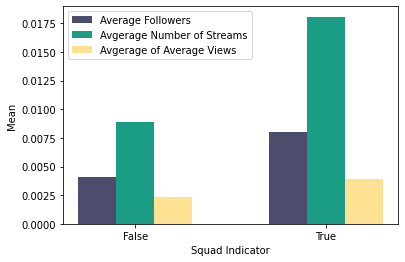

In [4]:
df.followers -= df.followers.min()
df.followers /= df.followers.max()

df.nr_streams -= df.nr_streams.min()
df.nr_streams /= df.nr_streams.max()

df.views_avg -= df.views_avg.min()
df.views_avg /= df.views_avg.max()

grouped_df = df.groupby('treatment').mean()

# Get the feature names
features = ["followers", "nr_streams", "views_avg"]

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = range(len(grouped_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the barplot
plt.bar(r1, grouped_df['followers'], color='#4C4C6D', width=bar_width, label='Average Followers')
plt.bar(r2, grouped_df['nr_streams'], color='#1B9C85', width=bar_width, label='Avgerage Number of Streams')
plt.bar(r3, grouped_df['views_avg'], color='#FFE194', width=bar_width, label='Avgerage of Average Views')

# Set the x-axis labels
plt.xticks([r + bar_width for r in range(len(grouped_df))], grouped_df.index)

# Set the y-axis label
plt.ylabel('Mean')
plt.xlabel('Squad Indicator')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [5]:
df[df["treatment"] == True].followers.mean() - df[df["treatment"] == False].followers.mean()

In [6]:
common_causes = ["nr_streams", "views_avg"]
model = CausalModel(data = df, treatment = "treatment", outcome ='followers', common_causes = common_causes)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",
                                 target_units="ate", confidence_intervals=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                         
────────────(E[followers|nr_streams,views_avg])
d[treatment]                                   
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→followers then P(followers|treatment,nr_streams,views_avg,U) = P(followers|treatment,nr_streams,views_avg)

## Realized estimand
b: followers~treatment+nr_streams+views_avg
Target units: ate

## Estimate
Mean value: 0.0013307039458954686

Causal Estimate is 0.0013307039458954686


In [7]:
estimate.get_confidence_intervals(confidence_level=0.9, num_simulations=1000)

In [8]:
estimate.test_stat_significance()

{'p_value': (0, 0.001)}

In [9]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.0013307039458954686
New effect:0.0013481726045924203
p value:0.9199999999999999



In [10]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")

print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.0013307039458954686
New effect:-0.0028995068834321873
p value:0.0

